# Implementation of DDPG algorithm to learn to balance the Cart-Pole task in Deepmind Control suite domain. Learning accelerates if connected with T4 GPU. Results are saved for the implementation below and it will take less than 25 minutes to train for all three seeds.


In [ ]:
# Install dm_control and dependencies
!pip install dm_control
!pip install imageio
!pip install matplotlib

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dm_control import suite
from collections import deque
import random
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 126.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 13.0 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/glfw/__init__.py:917: GLFWError: (65550) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


Using device: cuda


In [ ]:
# Replay buffer to store experiences
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (np.array(state), np.array(action), np.array(reward).reshape(-1, 1),
                np.array(next_state), np.array(done).reshape(-1, 1))

    def __len__(self):
        return len(self.buffer)


class GaussianNoise:
    def __init__(self, action_dim, sigma=0.2):
        self.action_dim = action_dim
        self.sigma = sigma # standard deviation of noise

    def sample(self):
        return self.sigma * np.random.randn(self.action_dim) #select noise from N(0,sigma)

    def reset(self):
        pass

# Actor and Critic networks
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = torch.relu(self.l1(state))
        x = torch.relu(self.l2(x))
        x = self.max_action * torch.tanh(self.l3(x))
        return x

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(state_dim + action_dim, 400) # critic takes (state + action) as input
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, state, action):
        q = torch.relu(self.l1(torch.cat([state, action], 1)))
        q = torch.relu(self.l2(q))
        return self.l3(q)

# DDPG algorithm
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor) #copy the network with parameters
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4) # learning rate as 0.0001

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3) #learning rate = 0.001

        self.max_action = max_action
        self.replay_buffer = ReplayBuffer()
        self.discount = 0.99 # gamma as discount factor
        self.tau = 0.005 #parameter for soft update

    def select_action(self, state, noise=None):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        action = self.actor(state).cpu().data.numpy().flatten()
        if noise is not None:
            action = action + noise
        return np.clip(action, -self.max_action, self.max_action)

    def train(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return

        # Sample from buffer
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        state = torch.FloatTensor(state).to(device)
        action = torch.FloatTensor(action).to(device)
        reward = torch.FloatTensor(reward).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(done).to(device)


        with torch.no_grad(): #compute target q without calculating gradient
            target_action = self.actor_target(next_state)
            target_Q = self.critic_target(next_state, target_action)
            target_Q = reward + (1 - done) * self.discount * target_Q #target = reward + gamma*Q_(target)(next_state,next_action)


        current_Q = self.critic(state, action) # Compute Current Q

        # Critic Loss
        critic_loss = nn.MSELoss()(current_Q, target_Q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor Loss (maximize Q-value)
        actor_loss = -self.critic(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft Update Targets
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

In [ ]:
def get_flat_obs(time_step):
    obs = time_step.observation # Flattens the observation dictionary into a single numpy array
    return np.concatenate([obs[k].ravel() for k in obs])

def run_training(seed_list, total_episodes=150):
    all_rewards = [] #store rewards for all training

    for seed in seed_list:
        print(f"\nTraining on Seed {seed}")
        #load environment for cartpole balance with each seed
        env = suite.load(domain_name="cartpole", task_name="balance", task_kwargs={'random': seed})

        #get action and observation dimension for cartpole task
        action_spec = env.action_spec()
        state_dim = get_flat_obs(env.reset()).shape[0] #flatten and store the shape
        action_dim = action_spec.shape[0] #get the dimension for action space
        max_action = action_spec.maximum[0] #maximum action allowed for cartpole


        agent = DDPGAgent(state_dim, action_dim, max_action) #instantiate the agent
        noise = GaussianNoise(action_dim, sigma=0.2) #get a random gaussian noise

        seed_rewards = []

        for episode in range(total_episodes):
            time_step = env.reset()
            state = get_flat_obs(time_step)
            noise.reset()
            episode_reward = 0

            while not time_step.last():
                # Select action with noise
                action = agent.select_action(state, noise.sample())

                # Step environment
                time_step = env.step(action)
                next_state = get_flat_obs(time_step)
                reward = time_step.reward
                done = time_step.last()

                # Store in buffer
                agent.replay_buffer.push(state, action, reward, next_state, float(done))

                # Train agent
                agent.train(batch_size=64)

                state = next_state
                episode_reward += reward

            seed_rewards.append(episode_reward)

            if (episode + 1) % 10 == 0:
                print(f"Seed {seed} | Episode {episode+1}/{total_episodes} | Reward: {episode_reward:.2f}")

        all_rewards.append(seed_rewards)

    return np.array(all_rewards), agent # Return last agent for evaluation


Training on Seed 0
Seed 0 | Episode 10/80 | Reward: 363.40
Seed 0 | Episode 20/80 | Reward: 693.71
Seed 0 | Episode 30/80 | Reward: 691.34
Seed 0 | Episode 40/80 | Reward: 706.78
Seed 0 | Episode 50/80 | Reward: 760.68
Seed 0 | Episode 60/80 | Reward: 763.58
Seed 0 | Episode 70/80 | Reward: 895.91
Seed 0 | Episode 80/80 | Reward: 767.16

Training on Seed 1
Seed 1 | Episode 10/80 | Reward: 400.79
Seed 1 | Episode 20/80 | Reward: 523.67
Seed 1 | Episode 30/80 | Reward: 753.80
Seed 1 | Episode 40/80 | Reward: 737.74
Seed 1 | Episode 50/80 | Reward: 908.84
Seed 1 | Episode 60/80 | Reward: 888.80
Seed 1 | Episode 70/80 | Reward: 899.46
Seed 1 | Episode 80/80 | Reward: 859.61

Training on Seed 2
Seed 2 | Episode 10/80 | Reward: 274.79
Seed 2 | Episode 20/80 | Reward: 426.38
Seed 2 | Episode 30/80 | Reward: 770.14
Seed 2 | Episode 40/80 | Reward: 942.75
Seed 2 | Episode 50/80 | Reward: 976.33
Seed 2 | Episode 60/80 | Reward: 716.42
Seed 2 | Episode 70/80 | Reward: 632.51
Seed 2 | Episode 80/

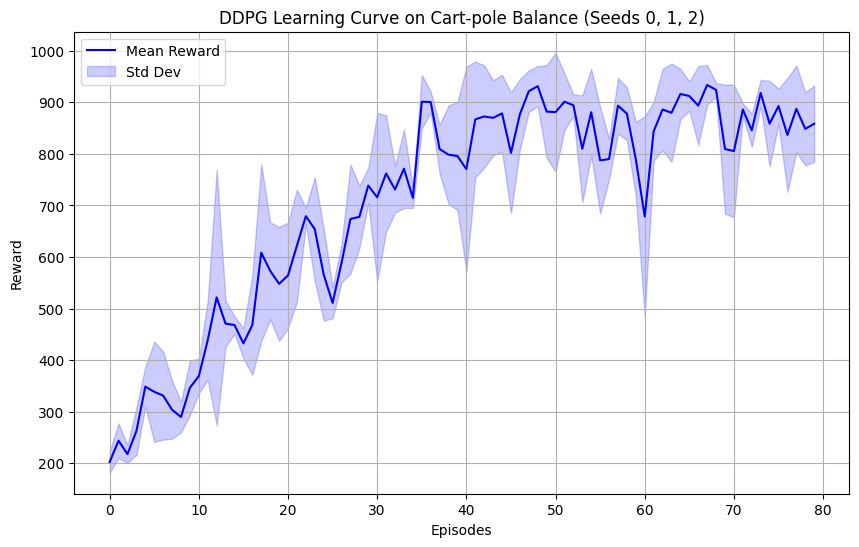

In [ ]:
#Training on seeds 0, 1, and 2. Usually takes 25 mins for trainig for all three seeds
seeds = [0,1,2]
training_data, trained_agent = run_training(seeds, total_episodes=80)

# plot the learning curves
mean_rewards = np.mean(training_data, axis=0)
std_rewards = np.std(training_data, axis=0)
epochs = np.arange(len(mean_rewards))

plt.figure(figsize=(10, 6))
plt.plot(epochs, mean_rewards, label="Mean Reward", color='blue')
plt.fill_between(epochs, mean_rewards - std_rewards, mean_rewards + std_rewards, color='blue', alpha=0.2, label="Std Dev")
plt.title("DDPG Learning Curve on Cart-pole Balance (Seeds 0, 1, 2)")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()


Evaluating on Seed 10
Total Evaluation Score: 952.65


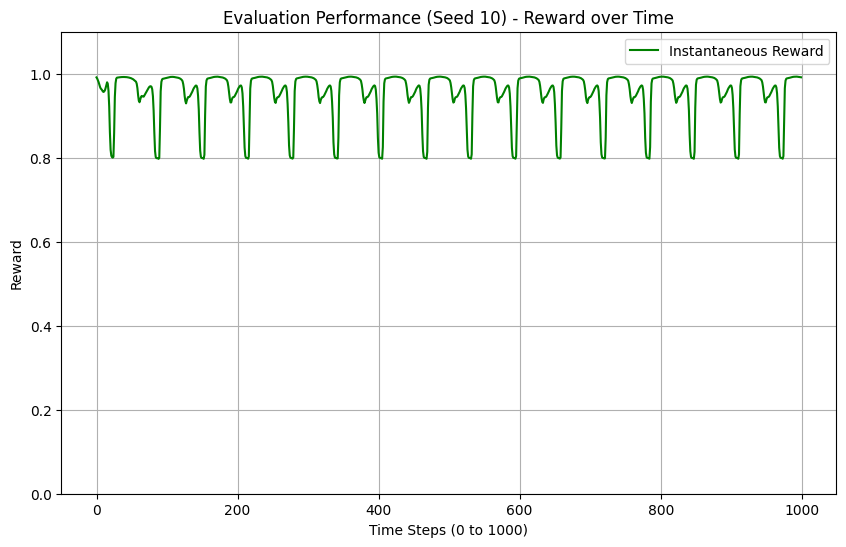

In [ ]:
#Evaluation for seed 10
import matplotlib.pyplot as plt

print("\nEvaluating on Seed 10")

eval_env = suite.load(domain_name="cartpole", task_name="balance", task_kwargs={'random': 10})
time_step = eval_env.reset()
state = get_flat_obs(time_step)
step_rewards = []

while not time_step.last():
    action = trained_agent.select_action(state, noise=None) #no noise when evaluating

    time_step = eval_env.step(action)
    state = get_flat_obs(time_step)
    step_rewards.append(time_step.reward)

print(f"Total Evaluation Score: {sum(step_rewards):.2f}")

plt.figure(figsize=(10, 6))
plt.plot(step_rewards, label="Instantaneous Reward", color='green')

plt.title("Evaluation Performance (Seed 10) - Reward over Time")
plt.xlabel("Time Steps (0 to 1000)")
plt.ylabel("Reward")
plt.ylim(0, 1.1) # Cartpole reward is between 0 and 1
plt.legend()
plt.grid(True)
plt.show()

Test Score: 952.86


/usr/local/lib/python3.12/dist-packages/glfw/__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


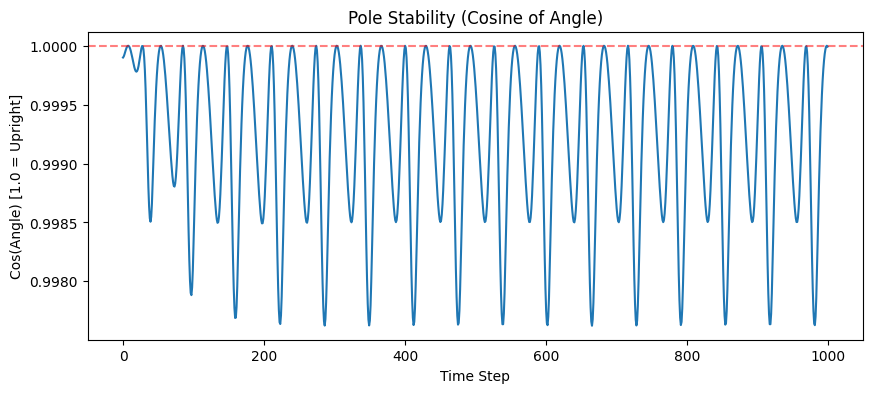

In [ ]:
# Create a new environment for testing
test_env = suite.load(domain_name="cartpole", task_name="balance", task_kwargs={'random': 3}) #randomly selected the new seed and can be checked with different
time_step = test_env.reset()
state = get_flat_obs(time_step)

cosine_values = []

while not time_step.last():
    obs_dict = time_step.observation
    position_data = obs_dict['position']
    pole_cos = position_data[1]

    cosine_values.append(pole_cos)

    action = trained_agent.select_action(state, noise=None)
    time_step = test_env.step(action)
    state = get_flat_obs(time_step)
    test_reward += time_step.reward

print(f"Test Score: {test_reward:.2f}")

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(cosine_values)
plt.title("Pole Stability (Cosine of Angle)")
plt.xlabel("Time Step")
plt.ylabel("Cos(Angle) [1.0 = Upright]")
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
plt.show()
test_reward = 0

# The stability can be seen from the angle of cart which is almost fluctuating between 0.9 and 1 which implies that the DDPG agent is able to stabilize the pole upright successfully in all timesteps.